In [39]:
import pandas as pd
from pandas import set_option
from IPython import get_ipython
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

<br>
Загружаем пакеты и исходные данные

In [40]:
# Загрузка данных из файла CSV
dataset = pd.read_csv('V3_dataset.csv')

# Печать первых 5 строк данных, чтобы проверить, как они выглядят
dataset.head()

,Unnamed: 0,R&D Spend,Administration,Marketing Spend,State,Profit
0,0,165349.20,136897.80,471784.10,New York,192261.83
1,1,162597.70,151377.59,443898.53,California,191792.06
2,2,153441.51,NaN,407934.54,Florida,191050.39
3,3,144372.41,NaN,383199.62,New York,182901.99
4,4,142107.34,91391.77,366168.42,Florida,166187.94


---
## Ознакомление с данными с помощью методов описательной статистики

<br>
Определяем размерность набора данных:

In [41]:
dataset.shape

(50, 6)

<br>
Определяем типы атрибутов в данных:

In [42]:
dataset.dtypes

,0
Unnamed: 0,int64
R&D Spend,float64
Administration,float64
Marketing Spend,float64
State,object
Profit,float64


<br>
Посмотрим информацию о нашем DataFrame, обратим внимание на количество ненулевых значений:

In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       50 non-null     int64  
 1   R&D Spend        50 non-null     float64
 2   Administration   27 non-null     float64
 3   Marketing Spend  50 non-null     float64
 4   State            50 non-null     object 
 5   Profit           50 non-null     float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.5+ KB


Получение более подробных сведений по проблемному атрибуту Administration
(пропуски данных)

In [44]:
dataset["Administration"].value_counts()

,count
Administration,
136897.80,1
129219.61,1
135426.92,1
124153.04,1
154806.14,1
127382.30,1
96189.63,1
84710.77,1
118546.05,1


<br>
Столбец "State" представляет собой категориальный атрибут. Выясним, какие штаты представлены в выборке, и сколько стартапов от каждого штата представлено:

In [45]:
dataset["State"].value_counts()

,count
State,
New York,17
California,17
Florida,16


Удаление несущественных данных. В нашей выборке параметр "Unnamed: 0" хранит номер записи, который не интересует нас в рамках текущей задачи.
<br>
После коррекции выборки отобразим сводку по числовым атрибутам:

In [46]:
dataset = dataset.drop("Unnamed: 0", axis=1)
set_option('display.precision', 3)
dataset.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000,27.000,50.000,50.000
mean,73721.616,125206.423,211025.098,112012.639
std,45902.256,30085.898,122290.311,40306.180
min,0.000,51743.150,0.000,14681.400
25%,39936.370,99548.025,129300.133,90138.902
50%,73051.080,129219.610,212716.240,107978.190
75%,101602.800,147958.910,299469.085,139765.977
max,165349.200,182645.560,471784.100,192261.830


###### count - сумма; mean - среднее арифметическое; std - стандартное отклоение (корень из дисперсии)min - минимальное значение; max - максимальное значение; 25% - первый квартиль (Q1) - значение, ниже которого лежит 25% данных; 50% - второй квартиль; 75% - третий квартиль;

---
## Визуализация данных

- Одномерная

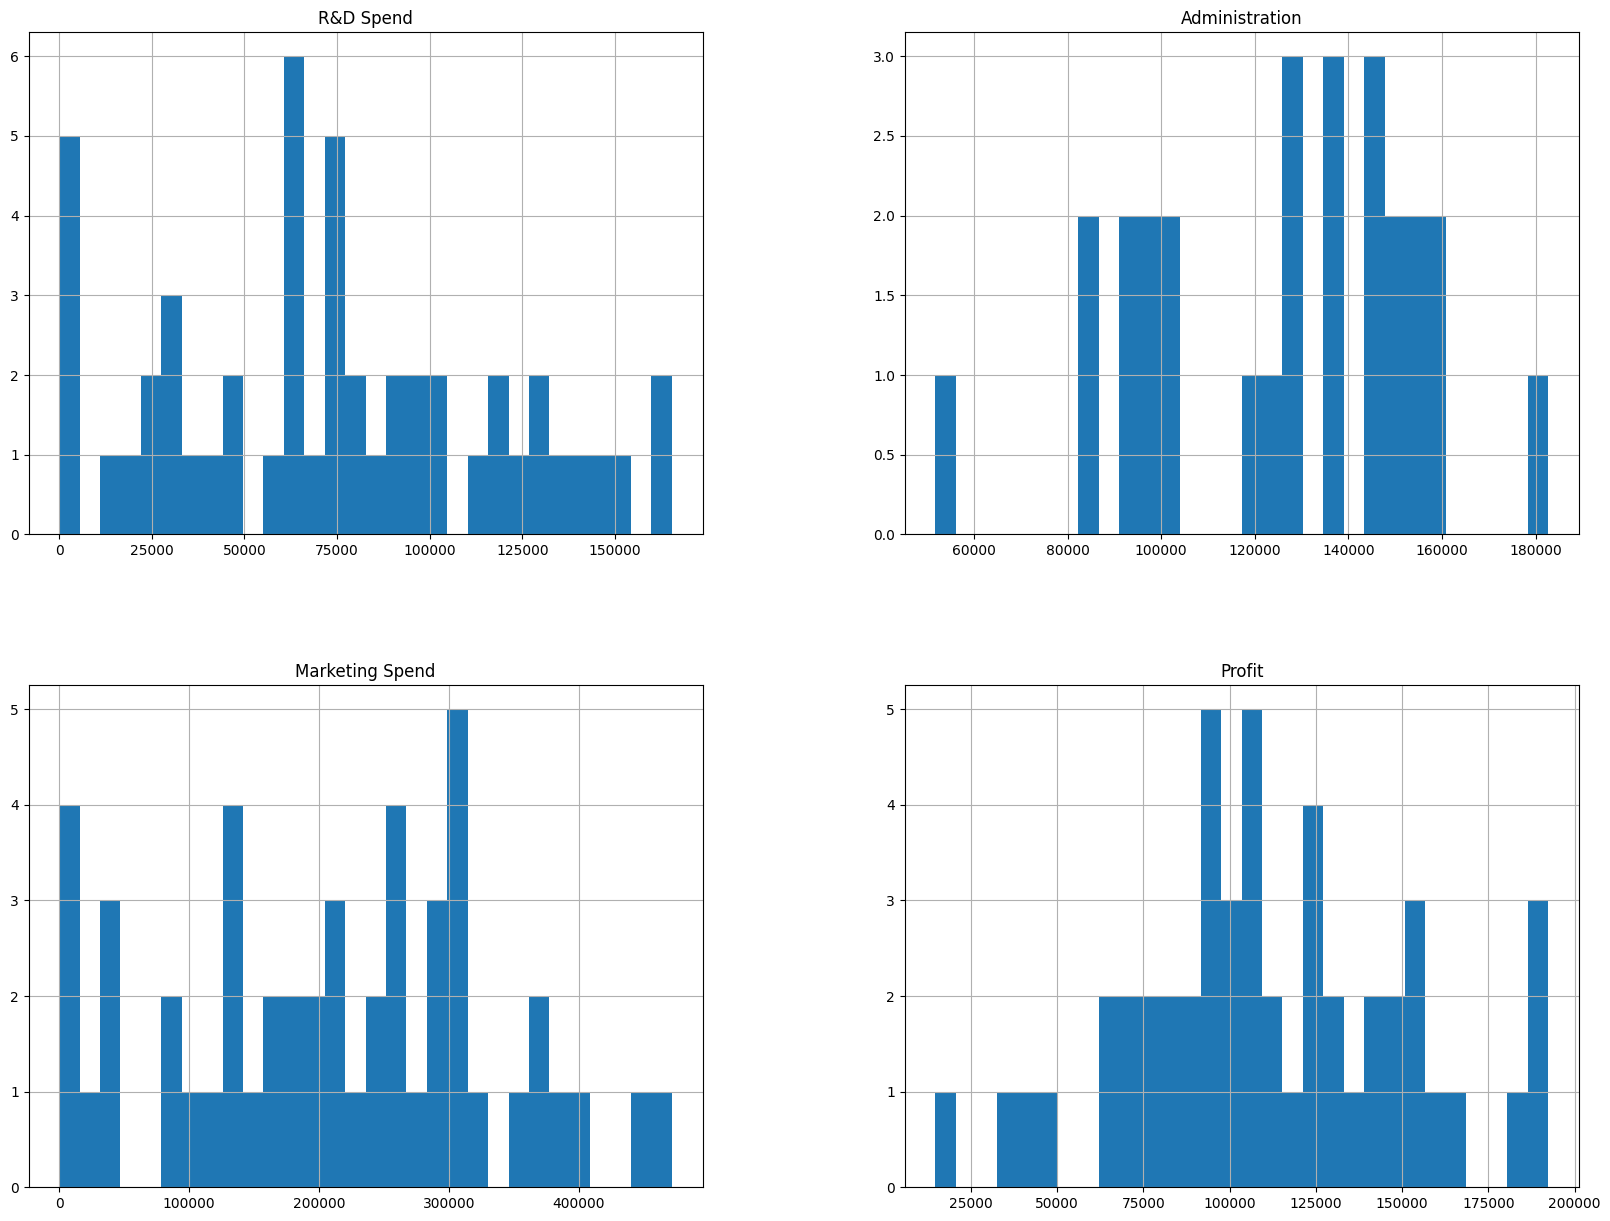

In [47]:

get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline



dataset.hist(bins = 30, figsize = (20,15))
plt.show()




Из представленых графиков неясно, близко ли распределние данных в выборке к нормальному распределению.
<br>
Постоим графики плотности для дополнительной визуализации данных.

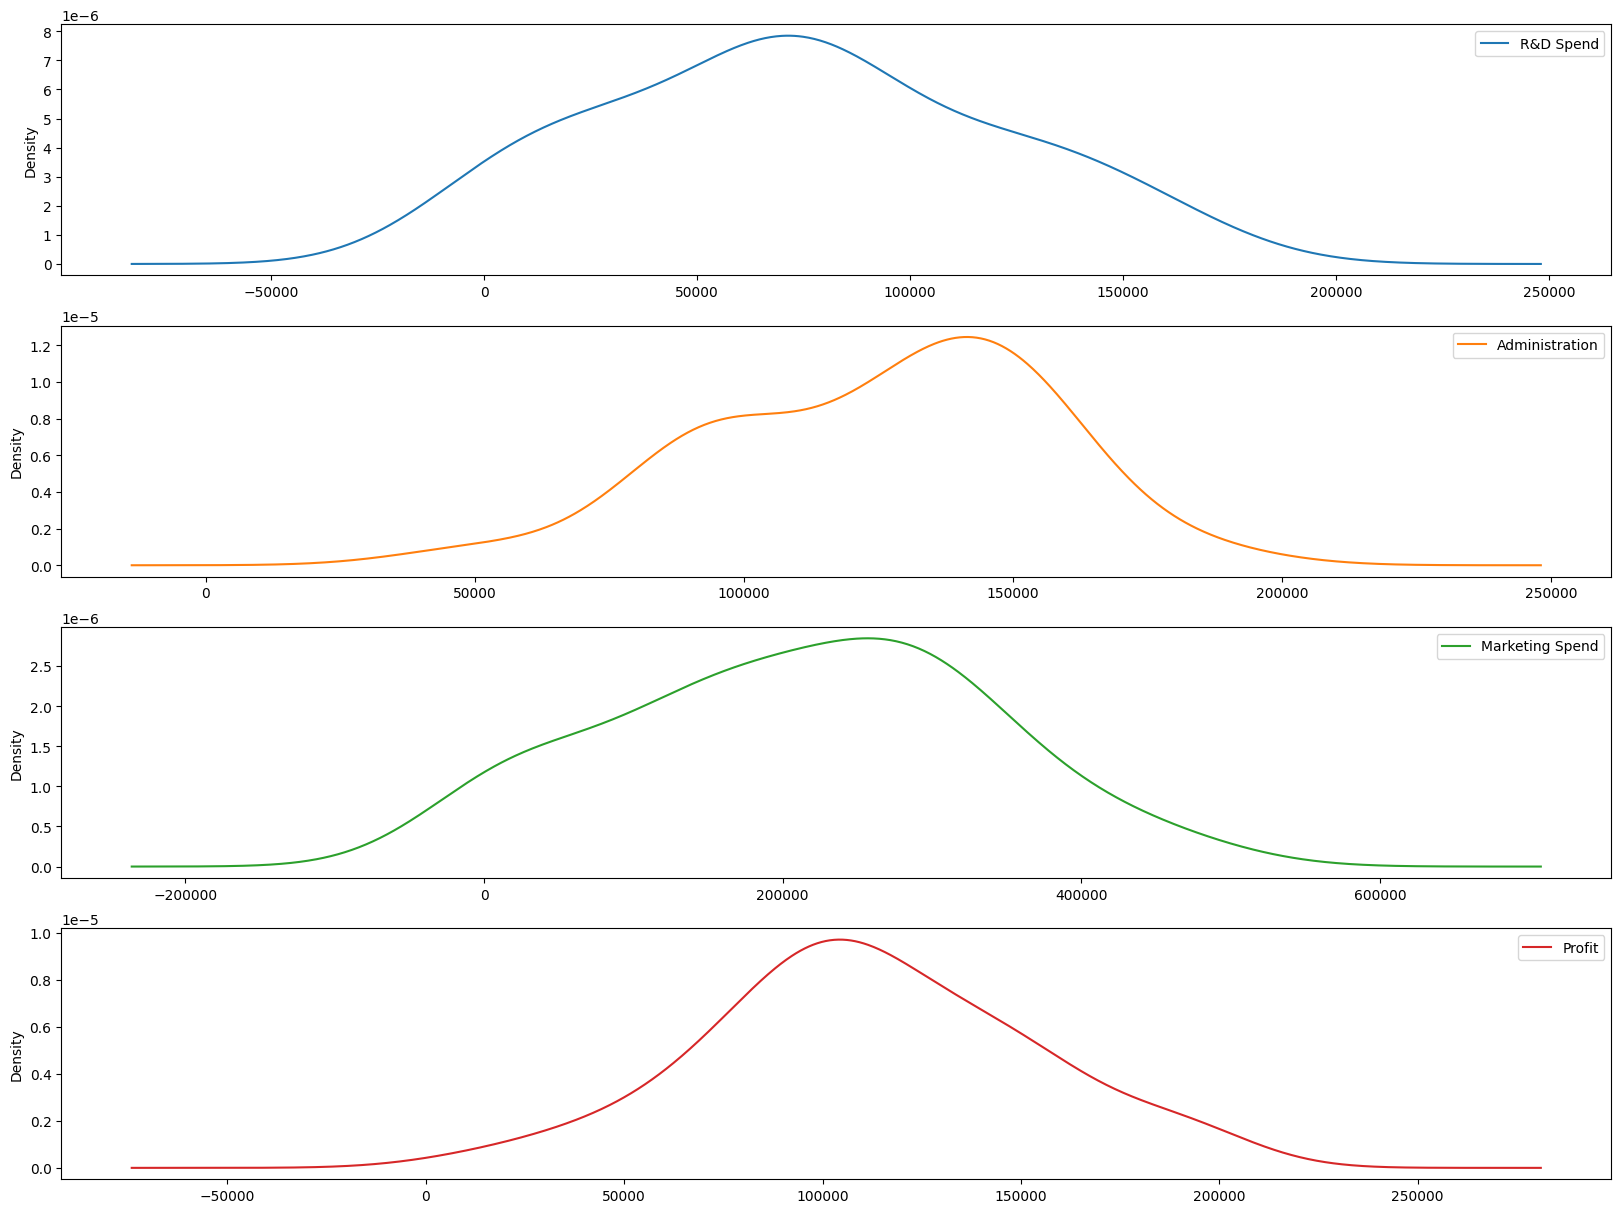

In [48]:
dataset.plot(kind="density", subplots=True, sharex=False, figsize=(20,15))
plt.show()

Графики плотности близки к колоколу, что косвенно может указывать на нормальное распределение

Построение матрицы диаграммы рассеивания

array([[<Axes: xlabel='R&D Spend', ylabel='R&D Spend'>,
        <Axes: xlabel='Administration', ylabel='R&D Spend'>,
        <Axes: xlabel='Marketing Spend', ylabel='R&D Spend'>,
        <Axes: xlabel='Profit', ylabel='R&D Spend'>],
       [<Axes: xlabel='R&D Spend', ylabel='Administration'>,
        <Axes: xlabel='Administration', ylabel='Administration'>,
        <Axes: xlabel='Marketing Spend', ylabel='Administration'>,
        <Axes: xlabel='Profit', ylabel='Administration'>],
       [<Axes: xlabel='R&D Spend', ylabel='Marketing Spend'>,
        <Axes: xlabel='Administration', ylabel='Marketing Spend'>,
        <Axes: xlabel='Marketing Spend', ylabel='Marketing Spend'>,
        <Axes: xlabel='Profit', ylabel='Marketing Spend'>],
       [<Axes: xlabel='R&D Spend', ylabel='Profit'>,
        <Axes: xlabel='Administration', ylabel='Profit'>,
        <Axes: xlabel='Marketing Spend', ylabel='Profit'>,
        <Axes: xlabel='Profit', ylabel='Profit'>]], dtype=object)

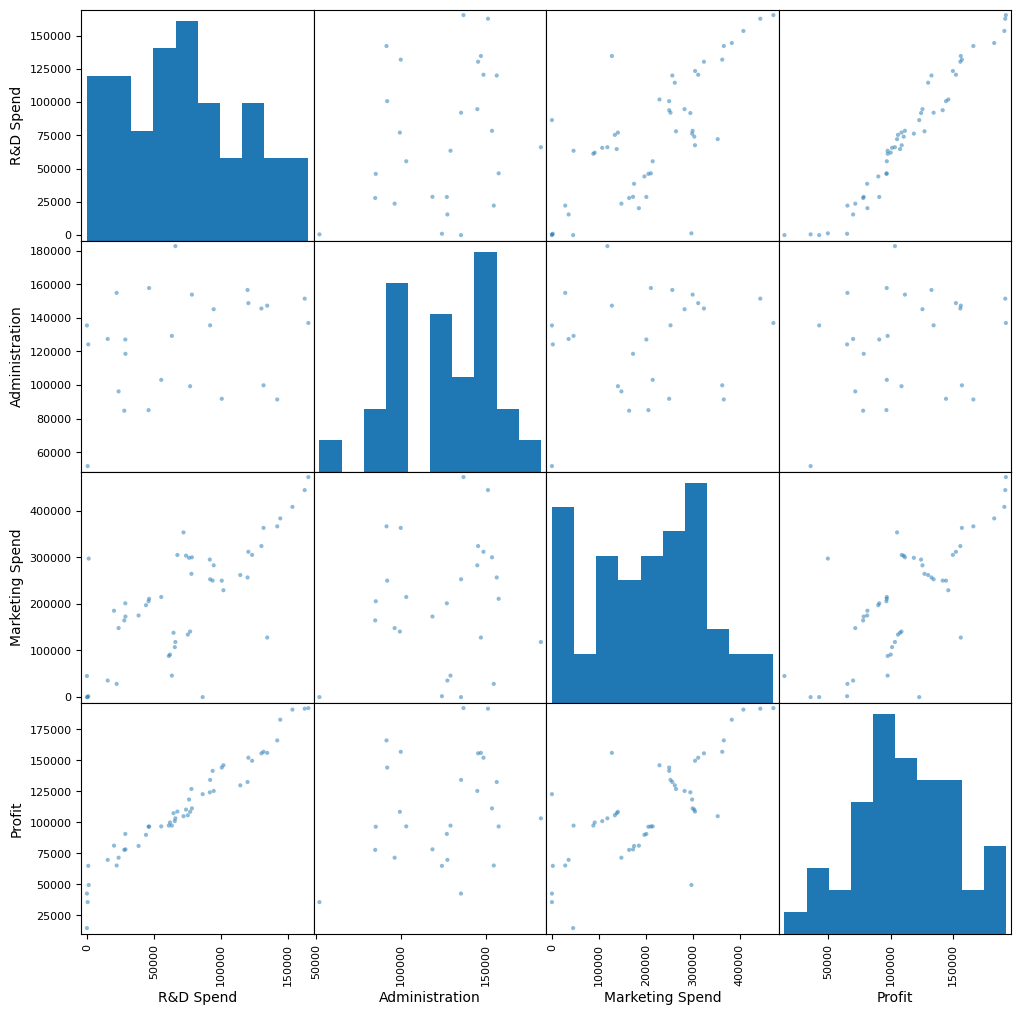

In [49]:
scatter_matrix(dataset, figsize=(12,12))

Построение корреляционной матрицы. Для этого придется исключить строковый атрибут(State).

<Axes: title={'center': 'Correlation Matrix'}>

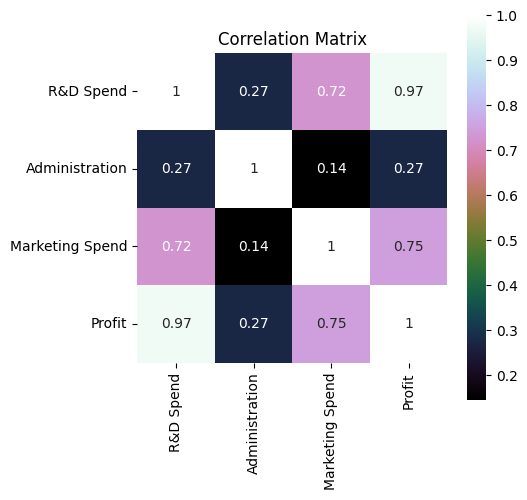

In [50]:
dataset = dataset.drop("State", axis=1)
dataset_corr = dataset.corr()
plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(dataset_corr, vmax=1, square=True, annot=True, cmap='cubehelix')

Поиск корреляционной зависимости
<br>
Вычисление стандартного коэффициента корреляции

In [51]:
dataset_corr

,R&D Spend,Administration,Marketing Spend,Profit
R&D Spend,1.000,0.274,0.724,0.973
Administration,0.274,1.000,0.145,0.272
Marketing Spend,0.724,0.145,1.000,0.748
Profit,0.973,0.272,0.748,1.000


Просмотр данных по конкретному атрибуту ('Profit')

In [52]:
dataset_corr["Profit"].sort_values(ascending=False)

,Profit
Profit,1.000
R&D Spend,0.973
Marketing Spend,0.748
Administration,0.272


Видно, что все атрибуты достаточно сильно связаны с прибылью(Profit). Так как атрибут Administration имеет много нечисловых значений(NaN) заполним их медианными значениями этого атрибута и заново вычислим стандартный коэффициент корреляции

In [53]:
dataset['Administration'].fillna(dataset['Administration'].median(), inplace=True)
dataset_corr = dataset.corr()
dataset_corr["Profit"].sort_values(ascending=False)

<ipython-input-53-79f955f92da2>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dataset['Administration'].fillna(dataset['Administration'].median(), inplace=True)


,Profit
Profit,1.000
R&D Spend,0.973
Marketing Spend,0.748
Administration,0.210
